# Coding Interview Problem: Make Two Robots Collide

Fifteen years ago when I was making the transition from academia into industray, I interviewed for a software developer job at Microsoft.  The interview was pretty standard, but there was one question that struck me as interesting.  After I was working, and started interviewing candidates myself, I often asked the same question.  It's an unorthodox question. I would never open an interview with it. I use it as a follow-up question for a candidate who does well on a more traditional coding question first.  The question probes algorithmic thinking and concurrency in a way that is separated from any specific familiar programming language.  It goes like this:


There are two identical robots on an infinite straight track.  Each robot can move left and right, can make a mark on the track beneath them, and can sense whether there is a mark beneath them.  Each robot can be programmed using the simple five-instruction assembly language described below.

> ## The Problem
> 
> Write a *single* program that, when executed simultaneously in both robots, will cause them to collide.  They begin an unknown distance apart.  When they begin, the track has no marks on it.
> 
> ### The Language
> Each robot has one-bit of input, indicating Robots are programmed using a simple language with five instructions.
> 
> * `moveleft` — Move a step to the left
> * `moveright` — Move a step to the right
> * `goto [label]`  — Program execution jumps to the labeled statement. (*Robot does not move*)
> * `ifmarkgoto [label]` — Program execution jumps to the labeled statement, only if there is a mark under the robot.  (*Robot does not move*)
> * `mark` — Make a mark under the robot.
>
> Any instruction can have a label at the beginning, so that `goto` and `ifmarkgoto` can find it.  E.g.:  `labelA: moveleft`.
>
> Every instruction takes one clock cycle to execute.
>
> Here is an example program that moves leftward from the starting point, making a mark every two steps:
> 
> ```
> loop: moveleft
>       moveleft
>       mark
>       goto loop
> ```

Think about it for a minute.

## A simulator

Before I get into solutions, a short digression.  It's no fun to talk about solutions if we can't run them, so here's a small simulator that will let us run our robot programs and look at how the robots behave.  **This is not part of the interview question**.  If you're not interested in how this works you can skip down to the solutions section.

The code below has three parts.

* The `Robot` class implements the robot.  It can be initialized with a string in the Robot language and has a `.runstep()` method that runs a single step of the program.  The robot's only internal state is its program and a program counter that tracks the next line of the program to execute.
* The functions `asm` and `parseinstruction` implement a tiny assembler.  `asm` takes a string containing a program in Robot assembly language and returns a list of `(op,arg)` tuples for the robot to execute.
* The `Track` class implements an an environment simulator.  It instantiates two robots at given positions with a given program and then runs them until the collide or a timeout is reached.

In [1]:
from typing import Optional,Tuple,List
ASMCmd = Tuple[Optional[str],str,Optional[str]]

class Robot:
    """
    A robot for our track. The robot is instantiated with 
    a robot assembly language program consisting of one
    instruction per line.  Its only internal state is its program
    and a program counter indicating what line to run next.
    """
    def __init__(self,code:str):
        self.program_counter = 0
        self.program = asm(code)
    
    def runstep(self,is_mark:bool)->None:
        """
        Run a step of the robot program, 
        
        Take as input whether or not there is a mark under the robot.
        
        Return a tuple (c,m) where
        
        c == the relative position change, {-1,0,1},
        m == whether or not to make a mark, {False,True}.
        .
        """
        op,arg = self.program[self.program_counter]
        makemark = False
        position_change = 0
        if op == 'moveleft':
            position_change = -1
            self.program_counter += 1
        elif op == 'moveright':
            position_change = 1
            self.program_counter += 1
        elif op == 'goto':
            self.program_counter += arg
        elif op == 'ifmarkgoto':
            self.program_counter += arg if is_mark else 1
        elif op == 'mark':
            makemark = True
            self.program_counter += 1
            
        return position_change,makemark
            
def asm(program:str) -> List[ASMCmd]:
    """
    Assemble a robot program from a string containing
    lines with commands to a list of command tuples.
    """
    labels = {}
    cmds = []
    lines = program.lower().strip().splitlines()
    for i,l in enumerate(lines):
        label,op,arg = parseinstruction(l)
        if label:
            labels[label] = i
        if arg:
            arg = labels[arg] - i
        cmds.append((op,arg))
        
    return cmds
        
def parseinstruction(codeline:str) -> ASMCmd:
    """
    Parse a single instruction in robot assembly into
    and intermediate representation as a tuple of 
    ([label], operation, [operand])
    """
    try:
        label,inst = codeline.split(":")
    except ValueError:
        label,inst = None,codeline
        
    try:
        op,arg = inst.split()
    except ValueError:
        op,arg = inst.strip(),None
        
    return label,op,arg



class Track:
    """
    The robot track simulator.  It is instantiated
    with two start positions and two robots.
    
    It runs the robots step-by-step either until the robots collide or a 
    a timeout is reached.  The state of the simulation at each step 
    is logged into the variable .log as a list of (time,position0,position1) 
    tuples.
    """
    def __init__(self,startpos0:int, startpos1:int, robot0:Robot, robot1:Robot):
        self.clock = 0
        self.positions = [startpos0,startpos1]
        self.robots = (robot0,robot1)
        self.marks = {}
        self.log = []
    
    def runstep(self) -> None:
        for i in 0,1:
            p,m = self.robots[i].runstep(self.marks.get(self.positions[i],False))
            self.positions[i] += p
            if m:
                self.marks[self.positions[i]] = True
        self.clock += 1
        self.update_log()

    def run(self,timeout:int=100) -> None :
        self.update_log()
        while self.clock < timeout and self.positions[0] != self.positions[1]:
            self.runstep()
            
    def update_log(self) -> None:
        self.log.append((self.clock,self.positions[0],self.positions[1]))
        
    def plot_log(self,title='',**kw):
        """
        Plot the positions of the robots through time.
        """
        import matplotlib.pyplot as plt
        
        time = [t for t,_,_ in self.log]
        p1 = [p for _,p,_ in self.log]
        p2 = [p for _,_,p in self.log]
        
        plt.plot(p1,time,label='Robot 0',**kw)
        plt.plot(p2,time, label='Robot 1',**kw)
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.set_major_formatter("{x:.0f}")

        plt.xlabel('Position')
        plt.ylabel('Time')
        plt.legend(loc='best')
        if title:
            plt.title(title)
        plt.show()

## Solutions

In that interview, my first crack at the problem was to try to break it down into an easier problem:  How could you program a single robot to collide with a second, stationary, robot.  The first robot doesn't know which direction to go to find the second one, so it would have to go back and forth in widening sweeps.  The robot can do this by moving in one direction as long as it has a mark beneath it, then when it finds and unmarked space, making a mark and repeating the same process in the other direction.  

The program to search this way looks like this:

In [2]:
back_and_forth = """

goleft:  mark
         moveleft
         ifmarkgoto goleft
goright: mark
         moveright
         ifmarkgoto goright
         goto goleft

"""


And it works. Here is a simulation of a single moving robot finding a stationary robot.   To show this, we'll need a program to keep the robot in one spot:

In [3]:
stationary = """

loop: goto loop

"""

Now we can instantiate those two robots on the track and run them.

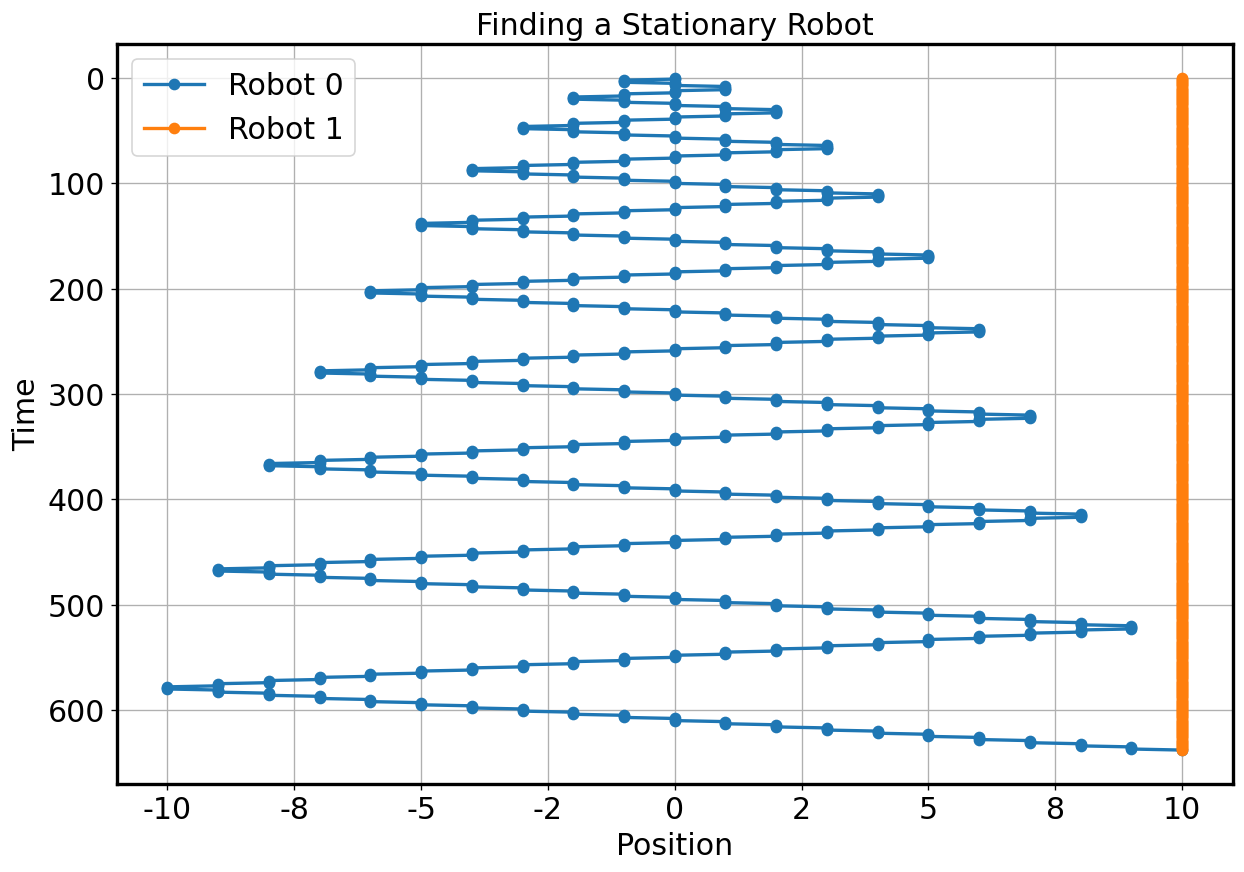

In [4]:
findsingle = Track(0,10,Robot(back_and_forth),Robot(stationary))
findsingle.run(10000)
findsingle.plot_log(title="Finding a Stationary Robot",marker='o')

Cool.  Robot 0 goes back and forthin widening sweeps until it collides with robot 1.  It's not fast, but it gets the job done.

But our problem states that both robots must be running running the same program.  If we give Robot 1 the same program as Robot 0, it will start off in the same direction.  How will they ever meet?  

Let's think about this.  Recall that the `back_and_forth` program places marks on all the ground that the robot covers, and the robot keeps going in the same direction whenever it is on marked ground. This means that eventually one robot will walk onto the ground marked by the other, at which point it will continue on in the same direction.  Meanwhile the other robot will reach unmarked ground and turn back, and eventually they will collide.

Let's see if that's what happens.

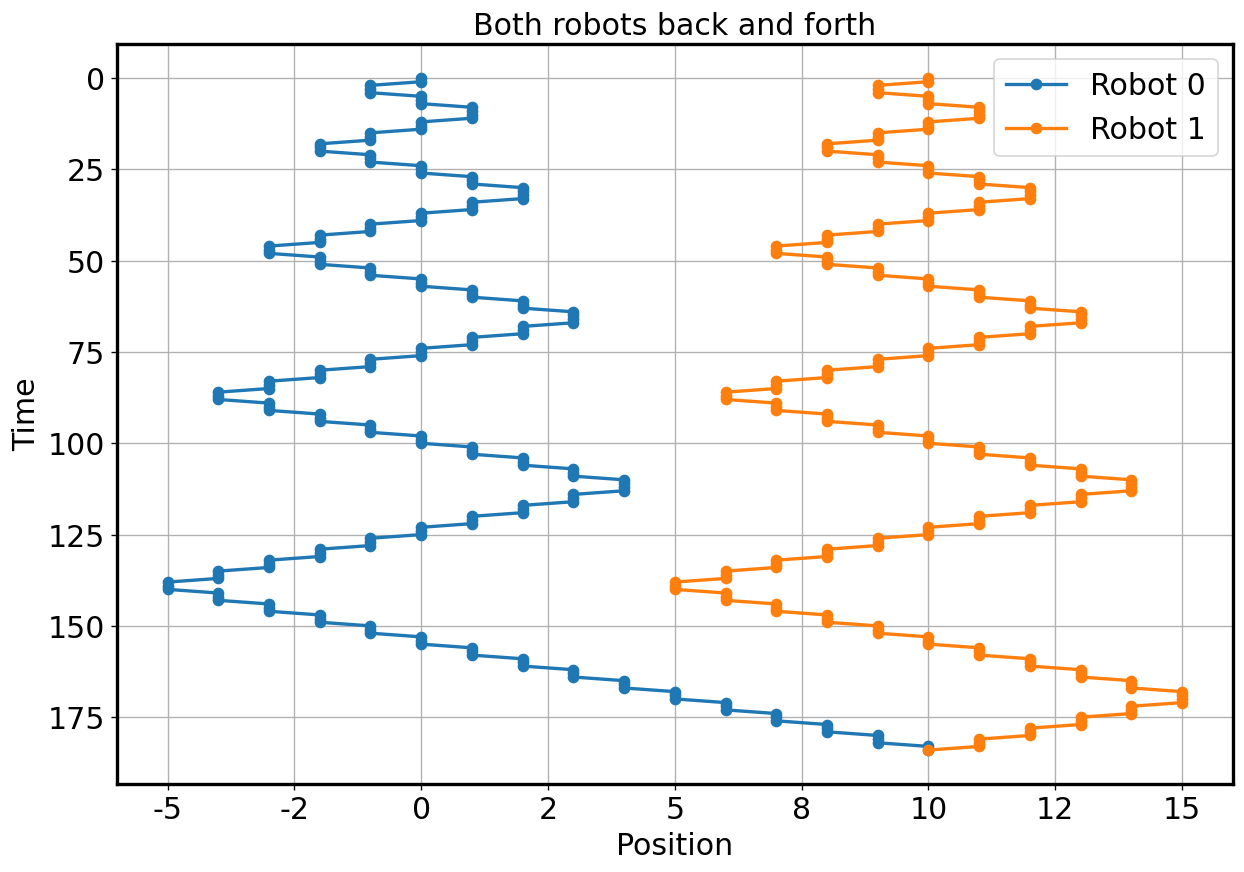

In [5]:
both_search = Track(0,10,Robot(back_and_forth),Robot(back_and_forth))
both_search.run(10000)
both_search.plot_log(title="Both robots back and forth",marker='o')

Not only do they collide, but they collide much faster than when one is stationary!   As predicted, around step 170, Robot 0 reaches position five, which already been trodden and marked by Robot 1.  Robot 0 continues on to the right while Robot 1 turns back to the left and they collide back at position ten.

## A faster solution

As I recall that interview from fifteen years ago, I had explained my approach and was trying to code it up on the whiteboard.  I had something approximating the `back_and_forth` program above, but I was struggling a bit. I can't remember exactly, but either I didn't have it coded up quite right, or I actually had the correct solution but I hadn't managed to convince either my interviewr or myself that it was right.  In any case, the interviewer stopped me.

"Okay, think about this," he said.  "If my dog runs away from me, do I necessarily have to get him to turn around to get him back?"

"I guess not," I said. "Not if you can run faster than your dog."

"Right. So how can you make one robot go faster than the other?"

The key element he was guiding me to was this line from the problem statement:

> Every instruction takes one clock cycle to execute.

If you look at the traces from the simulations above, you can see that the robots actually spends three clock cycles in each position, since each loop is three instructions long.  So the trick here is this: how can we make a program where both robots head off in the same direction, but the robot in back runs a shorter loop than the robot in front?

The key, as before, is to have each robot mark the ground it's covered and use those marks to trigger one robot to move to a different behavior when it finds the other robot's marks.


In [6]:
chase = """

slow:  mark
fast:  moveright
       ifmarkgoto fast
       goto slow

"""

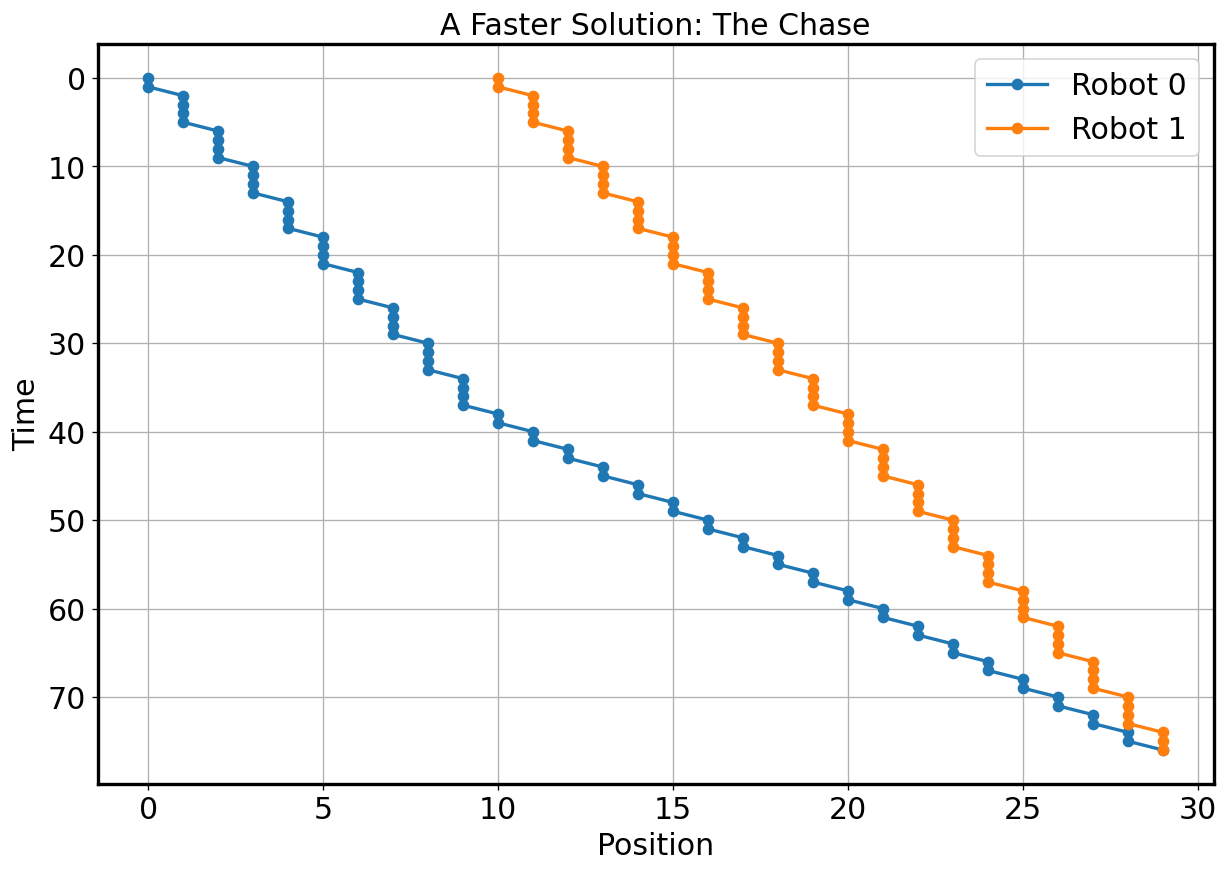

In [7]:
chasetrack = Track(0,10,Robot(chase),Robot(chase))
chasetrack.run(200)
chasetrack.plot_log(title="A Faster Solution: The Chase", marker='o')

This solution is both shorter and faster!  Only four lines of code, and the robots collide in less than half the time of the back-and-forth search method.  Unfortunately for me, I don't think I was able to get this solution in the remaining time of the interview session.


## Was the interviewer right?

While I can't remember exactly if I had found the correct back-and-forth solution, or if I was still struggling to get it right when my interviewer redirected me, but it's clear that I was on the right track my solution strategy, as stated in English, was a correct one, if not the most efficient.  I should have gotten some credit for that.  In fact, in a short interview session, the right strategy should be to find a correct solution first, then work on optimizing it.  Interviewers who try to redirect their candidates to a more efficient solution before a correct solution has been reached are doing their candidates a disservice.  it is almost the definition of premature optimization.